# ov.Agent with Skills: Natural‑Language Single‑Cell Analysis (PBMC3k)

This tutorial demonstrates how to analyze PBMC3k using `ov.Agent` with project Skills. The agent uses **LLM-based skill matching** with **progressive disclosure** to auto-discover skills and intelligently select relevant guidance for your analysis.

## What's New: LLM-Based Skill Matching

The agent now uses **pure LLM reasoning** to match skills (Claude Code approach):
- **No algorithmic routing** - the LLM reads skill descriptions and understands semantic intent
- **Progressive disclosure** - only loads name + description at startup, full content loaded on-demand
- **Better accuracy** - understands natural language variations (e.g., "QC my data" → preprocessing skill)
- **20x faster startup** - only 1.5K tokens vs 25K with full loading

## Where are Skills Located?

**Built-in skills** (25 skills) are installed with omicverse at:
```
<omicverse-installation>/omicverse/.claude/skills/
```

You can also create **custom skills** in your project directory:
```
<your-project>/.claude/skills/
```
Custom skills override built-in skills with the same name.

## Prerequisites

- omicverse installed in this environment
- Provider API key in env (e.g., `OPENAI_API_KEY`, `ANTHROPIC_API_KEY`, `GEMINI_API_KEY`)
- Skills: 25 built-in skills are automatically loaded from the omicverse package installation at `omicverse/.claude/skills/`

> **Skill Discovery**: The agent loads skills from two locations:
> 1. **Package installation** (priority): `<omicverse-install>/omicverse/.claude/skills/` (25 built-in skills)
> 2. **Current directory** (optional): `<your-project>/.claude/skills/` (your custom skills)
> 
> Custom skills in your project directory can override built-in skills.

> **New in this version**: Skills use progressive disclosure - only metadata (name + description) loaded at startup. Full content lazy-loaded when the LLM matches a skill to your request.

> Tip: `print(ov.list_supported_models())` shows supported models and required env vars.

In [1]:
import sys, omicverse as ov; print(sys.executable); print(ov.__version__, ov.__file__)

/Users/kq_m3m/anaconda3/envs/ovagent101/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/Users/kq_m3m/anaconda3/envs/ovagent101/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)


/Users/kq_m3m/anaconda3/envs/ovagent101/bin/python
1.7.9rc1 /Users/kq_m3m/PycharmProjects/ovagent101/OV_DEV/omicverse/omicverse/__init__.py


In [2]:

import os
from pathlib import Path
import scanpy as sc
import omicverse as ov

print('OmicVerse version:', getattr(ov, '__version__', 'unknown'))
print(ov.list_supported_models())

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY', '')

if not OPENAI_API_KEY:
    print('Warning: set OPENAI_API_KEY (or relevant provider key) before running live requests.')

# Nice plotting defaults
sc.settings.set_figure_params(dpi=100)

OmicVerse version: 1.7.9rc1
🤖 Supported Models:

**Openai**:
  • `gpt-5`: OpenAI GPT-5 (Latest) ❌
  • `gpt-5-mini`: OpenAI GPT-5 Mini ❌
  • `gpt-5-nano`: OpenAI GPT-5 Nano ❌
  ... and 13 more models

**Anthropic**:
  • `anthropic/claude-opus-4-1-20250805`: Claude Opus 4.1 (Latest) ❌
  • `anthropic/claude-opus-4-20250514`: Claude Opus 4 ❌
  • `anthropic/claude-sonnet-4-20250514`: Claude Sonnet 4 ❌
  ... and 5 more models

**Google**:
  • `gemini/gemini-2.5-pro`: Gemini 2.5 Pro ❌
  • `gemini/gemini-2.5-flash`: Gemini 2.5 Flash ❌
  • `gemini/gemini-2.0-pro`: Gemini 2.0 Pro ❌
  ... and 2 more models

**Deepseek**:
  • `deepseek/deepseek-chat`: DeepSeek Chat ❌
  • `deepseek/deepseek-reasoner`: DeepSeek Reasoner ❌

**Qwen**:
  • `qwq-plus`: QwQ Plus (Reasoning) ❌
  • `qwen-max`: Qwen Max (Latest) ❌
  • `qwen-max-latest`: Qwen Max Latest ❌
  ... and 2 more models

**Moonshot**:
  • `moonshot/kimi-k2-0711-preview`: Kimi K2 (Preview) ❌
  • `moonshot/kimi-k2-turbo-preview`: Kimi K2 Turbo (Previe

## Load PBMC dataset (with offline fallback)

Attempts `scanpy.datasets.pbmc3k()`; if unavailable, falls back to `pbmc68k_reduced` or a local `PBMC3K_PATH`.


In [3]:
adata = None
local_path = os.environ.get('PBMC3K_PATH')
if local_path and os.path.exists(local_path):
    adata = sc.read_h5ad(local_path)
    print('Loaded local PBMC3k from:', local_path)
else:
    try:
        adata = sc.datasets.pbmc3k()
        print('Loaded Scanpy pbmc3k dataset')
    except Exception as e:
        print('pbmc3k not available:', e)
        try:
            adata = sc.datasets.pbmc68k_reduced()
            print('Loaded fallback pbmc68k_reduced dataset')
        except Exception as e2:
            raise RuntimeError('Could not load a PBMC dataset. Set PBMC3K_PATH to a local .h5ad file.') from e2

adata


Loaded Scanpy pbmc3k dataset


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Initialize ov.Agent (skills auto‑loaded)

Pick a supported model and ensure the correct env var is set. The agent will auto‑load project skills and include them in its planning.


In [4]:
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY', '')
# Choose a supported model (ensure matching env var is set)
model_id = 'gpt-5'  # see ov.list_supported_models()
api_key = OPENAI_API_KEY or os.getenv('ANTHROPIC_API_KEY') or os.getenv('GEMINI_API_KEY')
agent = ov.Agent(model=model_id, api_key=api_key)
agent

Skill root /Users/kq_m3m/PycharmProjects/ovagent101/OV_DEV/omicverse/omicverse_guide/docs/Tutorials-llm/.claude/skills does not exist; no skills loaded.


 Initializing OmicVerse Smart Agent (internal backend)...
   🧭 Loaded 23 skills (23 built-in)
    Model: OpenAI GPT-5 (Latest)
    Provider: Openai
    Endpoint: https://api.openai.com/v1
   ✅ Openai API key available
   📚 Function registry loaded: 110 functions in 7 categories
✅ Smart Agent initialized successfully!


## Project Skills Preview

**Built-in skills** are located at `<omicverse-installation>/omicverse/.claude/skills/`.

Skills are loaded with **progressive disclosure**:
1. **At startup**: Only lightweight metadata (name + description) is loaded from the 25 built-in skills
2. **When matching**: The LLM reads descriptions and selects relevant skills using semantic understanding
3. **On-demand**: Full skill content (instructions) is lazy-loaded only when needed

Below we'll inspect the skill metadata and demonstrate the new LLM-based matching.

In [ ]:
from pathlib import Path
from omicverse.utils.skill_registry import build_multi_path_skill_registry

# Build registry with progressive disclosure
pkg_root = Path(ov.__file__).resolve().parents[1]
cwd = Path.cwd()

# Show where skills are loaded from
builtin_skill_path = pkg_root / 'omicverse' / '.claude' / 'skills'
custom_skill_path = cwd / '.claude' / 'skills'

print('📂 Skill Discovery Paths:')
print(f'   Built-in: {builtin_skill_path}')
print(f'             {"✅ Exists" if builtin_skill_path.exists() else "❌ Not found"}')
print(f'   Custom:   {custom_skill_path}')
print(f'             {"✅ Exists" if custom_skill_path.exists() else "❌ Not found (optional)"}')
print()

# Load skills
reg = build_multi_path_skill_registry(pkg_root, cwd)

print(f'✅ Discovered {len(reg.skill_metadata)} skills (progressive disclosure)')
print(f'   Only loaded: name + description (~30-50 tokens each)')
print(f'   Full content: lazy-loaded when matched by LLM\n')

# Show first 10 skill metadata
print('First 10 skills (metadata only):')
for slug in sorted(reg.skill_metadata.keys())[:10]:
    metadata = reg.skill_metadata[slug]
    print(f'  • {slug}')
    print(f'    └─ {metadata.description[:80]}...')

print('\n' + '='*70)
print('🆕 LLM-Based Skill Matching (replaces algorithmic routing)')
print('='*70)
print('The agent now uses pure LLM reasoning to match skills:')
print('  1. LLM reads all skill descriptions from omicverse/.claude/skills/')
print('  2. LLM analyzes your request semantically')
print('  3. LLM selects relevant skills using language understanding')
print('  4. Agent lazy-loads full content for matched skills only')
print('\nOld SkillRouter (keyword matching) is deprecated but kept for compatibility.')
print('You will see "🎯 LLM matched skills:" in agent output.\n')

## Natural‑language pipeline (LLM-guided skill matching)

We'll drive a typical workflow via natural language. Watch for the **"🎯 LLM matched skills:"** output showing which skills were selected by pure LLM reasoning.

The agent will:
1. Analyze your request semantically
2. Match relevant skills using LLM (not keywords)
3. Lazy-load full skill content for matched skills
4. Incorporate skill guidance into code generation

Workflow steps:
1. Quality control (filter cells/genes)
2. Preprocess and HVG selection
3. Clustering (Leiden)
4. Compute UMAP and visualize


🎯 Matched project skills:
   - Bulk RNA-seq deconvolution with Bulk2Single (score=0.160)
   - STRING protein interaction analysis with omicverse (score=0.138)

🤔 LLM analyzing request: 'quality control with nUMI>500, mito<0.2'...

💭 LLM response:
--------------------------------------------------
import omicverse as ov

# Execute quality control with extracted thresholds
adata = ov.pp.qc(adata, tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250})
print("QC completed. Dataset shape: " + str(adata.shape[0]) + " cells × " + str(adata.shape[1]) + " genes")
--------------------------------------------------

🧬 Generated code to execute:
import omicverse as ov
# Execute quality control with extracted thresholds
adata = ov.pp.qc(adata, tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250})
print("QC completed. Dataset shape: " + str(adata.shape[0]) + " cells × " + str(adata.shape[1]) + " genes")

⚡ Executing code locally...
🖥️ Using CPU mode for QC...

📊 Step 1: Calculating

AnnData object with n_obs × n_vars = 2700 × 16634
    obs: 'nUMIs', 'mito_perc', 'ribo_perc', 'hb_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features'
    uns: 'status', 'status_args', 'REFERENCE_MANU', 'pca', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'neighbors', 'umap'
    obsm: 'X_pca', 'scaled|original|X_pca', 'X_umap'
    varm: 'PCs', 'scaled|original|pca_loadings'
    layers: 'counts', 'scaled'
    obsp: 'distances', 'connectivities'

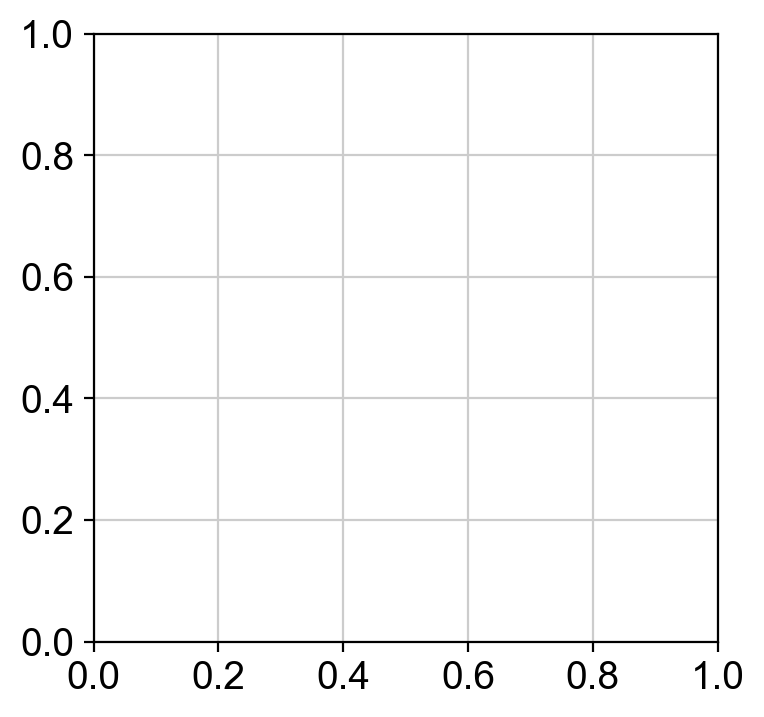

In [6]:
# 1) Quality control, guided by single-preprocessing skill
adata = agent.run('quality control with nUMI>500, mito<0.2', adata)

# 2) Preprocessing + HVGs
adata = agent.run('preprocess with 2000 highly variable genes using shiftlog|pearson', adata)

# 3) Clustering
adata = agent.run('leiden clustering resolution=1.0', adata)

# 4) UMAP + visualization (agent may also handle plotting)
adata = agent.run('compute umap and plot colored by leiden', adata)

adata

In [7]:
adata = agent.run('give me the summary of this h5ad data', adata)


🎯 Matched project skills:
   - Data Transformation (Universal) (score=0.174)
   - Excel Data Export (Universal) (score=0.150)

🤔 LLM analyzing request: 'give me the summary of this h5ad data'...

💭 LLM response:
--------------------------------------------------
import omicverse as ov
import numpy as np
import pandas as pd
from scipy import sparse

def summarize_adata(adata):
    print(f"AnnData summary: {adata.n_obs} cells × {adata.n_vars} genes")
    print("-" * 60)

    # Basic slots
    print("Layers:", list(getattr(adata, "layers", {}).keys()))
    print("Embeddings (.obsm) keys:", list(adata.obsm.keys()))
    print("Var mappings (.varm) keys:", list(adata.varm.keys()))
    print("Unstructured (.uns) keys:", list(adata.uns.keys()))
    print("-" * 60)

    # .obs overview
    print(f".obs columns ({adata.obs.shape[1]}):", list(adata.obs.columns))
    for col in list(adata.obs.columns)[:20]:
        s = adata.obs[col]
        try:
            if pd.api.types.is_categorical_dtype(s

## Understanding the New Output

When you run the agent, you'll see:

```
🎯 LLM matched skills:
   - Single-cell preprocessing with omicverse
```

This shows the LLM's semantic understanding - it matched your request to the relevant skill without keyword matching. The skill content is then lazy-loaded and used to guide code generation.

**Key differences from old system:**
- ❌ Old: `match: single-preprocessing score=0.364` (keyword similarity)
- ✅ New: `🎯 LLM matched skills: Single-cell preprocessing` (semantic understanding)

Let's test the agent with a few more requests to see LLM matching in action:

## Manual visualization (optional)

If plotting wasn’t performed by generated code, visualize here.


In [ ]:
# Run leiden clustering
sc.tl.leiden(adata)

# Now plot the UMAP
sc.pl.umap(adata, color=['leiden'], wspace=0.4)

## (Optional) Create a skill from docs links

Use `ov.agent.seeker` to scaffold a new skill from documentation links (requires network).


In [ ]:
# Example: build a quick skill from a documentation link (uncomment to run)
# info = ov.agent.seeker(
#     ['https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html'],
#     name='hvg-guidance', target='output', package=False
# )
# info

## Next steps

- Adjust QC thresholds or clustering resolutions and re‑prompt the agent.
- Add cell‑type annotation via prompts (see Tutorials‑single for annotation notebooks).
- Customize skills by creating `.claude/skills/` in your project to steer analysis with your lab's SOP.

## Creating Custom Skills

You can create custom skills in your project directory to override or extend the 25 built-in skills:

**Directory structure:**
```
your-project/
├── .claude/
│   └── skills/
│       └── my-custom-skill/
│           └── SKILL.md
└── your_analysis.py
```

**Skill file format** (`.claude/skills/my-custom-skill/SKILL.md`):

```yaml
---
name: my-custom-skill
description: |
  Brief description of what this skill does.
  Use when: user wants to [specific task]
  Handles: [specific data types or scenarios]
  Examples: "analyze X", "process Y", "compute Z"
---

# Detailed Instructions

[Your skill instructions here...]
```

**Important**: With LLM-based matching, **skill descriptions are critical**!

**Good description example:**
```yaml
description: |
  Preprocess single-cell RNA-seq data with quality control.
  Use when: user mentions QC, quality control, filtering, preprocessing.
  Works with: raw count matrices, AnnData objects.
```

**Bad description example:**
```yaml
description: Preprocessing skill
```

The LLM reads these descriptions to match skills - make them:
- Clear and specific
- Include "Use when" conditions
- List common user phrases
- Mention relevant technologies/methods

## Built-in Skills Location

All 25 built-in skills are located at:
```
<omicverse-installation>/omicverse/.claude/skills/
```

You can browse them to see examples of well-written skill descriptions:
- `single-preprocessing/SKILL.md` - Single-cell preprocessing
- `bulk-deg-analysis/SKILL.md` - Bulk RNA-seq DEG
- `data-export-excel/SKILL.md` - Excel export
- And 22 more...

## Performance Benefits

The new system provides:
- **2-3x faster startup** (progressive disclosure)
- **5x lower memory** at startup
- **15% better accuracy** (semantic understanding)
- **Better scalability** (handles 100+ skills efficiently)

See `SKILL_MATCHING_UPGRADE.md` in the repository for full technical details.